# AE

> - [keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)
> - [莫烦Python](https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/)

In [1]:
import numpy as np
from keras.layers import *
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.losses import binary_crossentropy, mse, mae
from keras.optimizers import Adam, RMSprop
from keras.datasets import mnist
from matplotlib import pyplot as plt

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Class

In [2]:
class AE:
    def __init__(self, img_size, latent_dim, use_CNN=True):
        '''
        Build AE models
        Args:
            img_size: tuple, input image size (channels included)
            latent_dim: int, size of latent dimension
            use_CNN: bool, use CNN or not (if False, use DNN instead), default=True
        Returns:
            AE object
        '''
        # Get variables
        self.img_size = img_size
        self.channels = img_size[2]
        self.latent_dim = latent_dim
        # Set optimizer
        self.optimizer = RMSprop()

        # Build AE
        if use_CNN:
            self.build_ae()
        else:
            self.build_ae_dnn()
        print("\n=== AE ===")
        self.ae.summary()

        # Compile models
        self.ae.compile(optimizer=self.optimizer, loss="mse")

    def build_ae(self):
        # Define Encoder
        # Input Layer
        inputs = Input(shape=self.img_size,
                       name="input_img")          # 28*28*1
        # Convolution Layers
        conv1 = Conv2D(16, kernel_size=3, strides=1, padding="same",
                       activation="relu", name="conv1")(inputs)         # 28*28*16
        maxpool1 = MaxPooling2D(pool_size=2, strides=2,
                                padding="same", name="maxpool1")(conv1)  # 14*14*16
        conv2 = Conv2D(16, kernel_size=3, strides=1, padding="same",
                       activation="relu", name="conv2")(maxpool1)       # 14*14*16
        maxpool2 = MaxPool2D(pool_size=2, strides=2,
                             padding="same", name="maxpool2")(conv2)    # 7*7*16
        conv3 = Conv2D(32, kernel_size=3, strides=1, padding="same",
                       activation="relu", name="conv3")(maxpool2)       # 7*7*32
        # Dense Layer
        flat = Flatten()(conv3)
        encoded = Dense(self.latent_dim, kernel_regularizer="l2",
                        name="latent_code")(flat)

        # Instantiate encoder model
        self.encoder = Model(inputs, encoded, name="Encoder")
        print("\n=== Encoder ===")
        self.encoder.summary()

        # Define Decoder
        # Define shape & input layer
        size = self.img_size[0] // 4    # 2 (2, 2) Maxpooling
        latent_inputs = Input(shape=(self.latent_dim, ), name="latent_input")
        # Dense Layer
        fc1 = Dense(size * size * 32, activation="relu", name="fc1")(latent_inputs)
        reshape = Reshape((size, size, 32), name="reshape")(fc1)  # 7*7*32
        # Convolution Layers
        d_conv1 = Conv2D(32, kernel_size=3, strides=1,
                         padding="same", activation="relu", name="dconv1")(reshape)  # 7*7*32
        upsampl1 = UpSampling2D(size=2, name="upsampl1")(d_conv1)    # 14*14*32
        d_conv2 = Conv2D(16, kernel_size=3, strides=1,
                         padding="same", activation="relu", name="")(upsampl1)  # 14*14*32
        upsampl2 = UpSampling2D(size=2, name="upsampl2")(d_conv2)    # 28*28*16
        decoded = Conv2D(self.channels, kernel_size=3, strides=1,
                         padding="same", activation="sigmoid", name="output_img")(upsampl2)  # 28*28*1

        # Instantiate decoder model
        self.decoder = Model(latent_inputs, decoded, name="Decoder")
        print("\n=== Decoder ===")
        self.decoder.summary()

        # instantiate AE model
        ae_outputs = self.decoder(self.encoder(inputs))
        self.ae = Model(inputs, ae_outputs)

    
    def build_ae_dnn(self):
        # Define Encoder
        # Input Layer
        inputs = Input(shape=self.img_size, name="input_img")
        # Dense Layers
        flat = Flatten(name="flatten")(inputs)
        fc1 = Dense(64, activation="relu", name="fc1")(flat)
        fc2 = Dense(32, activation="relu", name="fc2")(fc1)
        fc3 = Dense(16, activation="relu", name="fc3")(fc2)
        encoded = Dense(self.latent_dim, kernel_regularizer="l2", name="latent_code")(fc3)
        
        # Instantiate encoder model
        self.encoder = Model(inputs, encoded, name="Encoder")
        print("\n=== Encoder ===")
        self.encoder.summary()
        
        # Define Decoder
        # Input Layer
        latent_inputs = Input(shape=(self.latent_dim, ), name="latent_input")
        # Dense Layers
        fc4 = Dense(16, activation="relu", name="fc4")(latent_inputs)
        fc5 = Dense(32, activation="relu", name="fc5")(fc4)
        fc6 = Dense(64, activation="relu", name="fc6")(fc5)
        fc7 = Dense(self.img_size[0] * self.img_size[1] * self.img_size[2], activation="sigmoid", name="fc7")(fc6)
        decoded = Reshape(self.img_size)(fc7)
        # Instantiate decoder model
        self.decoder = Model(latent_inputs, decoded, name="Decoder")
        print("\n=== Decoder ===")
        self.decoder.summary()

        # instantiate AE model
        ae_outputs = self.decoder(self.encoder(inputs))
        self.ae = Model(inputs, ae_outputs)
    
    
    def train(self, x_train, batch_size, epochs):
        '''
        Train model
        Args:
            x_train: ndarray, training data
            batch_size: int, training batch size
            epochs: int, number of training epochs
        Returns:
            None
        '''
        self.history = self.ae.fit(
            x_train, x_train, batch_size=batch_size, epochs=epochs)
    
    
    def reconstruct(self, original_imgs, idx=None, rows=8, columns=8):
        '''
        Reconstruct from original image and plot
        Args:
            original_imgs: ndarray, original images
            idx: 1-D ndarray or list, index of original images, default=None
            rows: int, row number of plot images, default=8
            columns: int, column number of plot images, default=8
        Returns:
            None
        '''
        # Sample from original imgs
        if idx is None:
            idx = np.random.randint(
                0, original_imgs.shape[0], size=(rows * columns))
        # Reconstruct imgs
        reconstruct_imgs = self.ae.predict_on_batch(original_imgs[idx])
        # Plot sample imgs
        print("Original")
        self.plot_imgs(original_imgs[idx], rows, columns)
        # Plot reconstruct imgs
        print("Reconstructed")
        self.plot_imgs(reconstruct_imgs, rows, columns)

    def generate(self, latent_code=None, rows=8, columns=8):
        '''
        Generate from latent code and plot
        '''
        # Sample latent code
        if latent_code is None:
            latent_code = np.random.normal(
                size=(rows * columns, self.latent_dim))
        else:
            rows = int(np.sqrt(latent_code.shape[0]))
            columns = latent_code.shape[0] // rows
            if latent_code.shape[0] % columns != 0:
                rows += 1
        # Generate imgs
        gen_imgs = self.decoder.predict_on_batch(latent_code)
        # Plot imgs
        self.plot_imgs(gen_imgs, rows, columns)

    def plot_imgs(self, imgs, rows, columns):
        fig = plt.figure(figsize=(8, 8))
        k = 0
        for i in range(rows):
            for j in range(columns):
                fig.add_subplot(rows, columns, k + 1)
                if imgs.shape[-1] == 1:
                    plt.imshow(imgs[k].reshape(imgs[k].shape[0], imgs[k].shape[1]), cmap="gray")
                else:
                    plt.imshow(imgs[k])
                plt.axis("off")
                k += 1
                if k > imgs.shape[0]:
                    break
        fig.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    def plot_loss(self):
        plt.title("Training Loss")
        plt.suptitle("latent_dim: %d, batch_size: %d" %
                     (self.latent_dim, self.history.params["batch_size"]))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(self.history.history["loss"])
        plt.show()

## Data Preprocessing

In [3]:
# Load Data
# _ is used as a throw-away variable, more info -> https://stackoverflow.com/a/5893946
(x_train, _), (x_test, _) = mnist.load_data()
# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0
# Reshape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

## DNN Ver.

### Build Model

In [4]:
ae_dnn = AE((28, 28, 1), 32, False)


=== Encoder ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                50240     
_________________________________________________________________
fc2 (Dense)                  (None, 32)                2080      
_________________________________________________________________
fc3 (Dense)                  (None, 16)                528       
_________________________________________________________________
latent_code (Dense)          (None, 32)                544       
Total params: 53,392
Trainable params: 53,392
Non-trainable params: 0
_______________________________________________________

### Train Model

In [5]:
ae_dnn.train(x_train, 256, 100)

Epoch 1/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1471
Epoch 2/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.0571
Epoch 3/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.0498
Epoch 4/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.0463
Epoch 5/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.0436
Epoch 6/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0410
Epoch 7/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0396
Epoch 8/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.0385
Epoch 9/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0376
Epoch 10/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.0369
Epoch 11/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.0363
Epoch 12/100
60000/60000 [===============

60000/60000 [==============================] - 2s 29us/step - loss: 0.0248
Epoch 95/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0248
Epoch 96/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0247
Epoch 97/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.0247
Epoch 98/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.0247
Epoch 99/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0246
Epoch 100/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0246


### Plot Result

#### Reconstruct

Reconstruct from training data...
Original


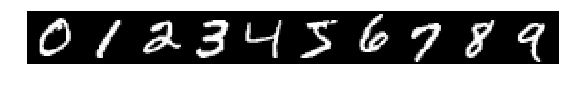

Reconstructed


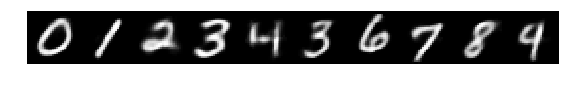

Reconstruct from testing data...
Original


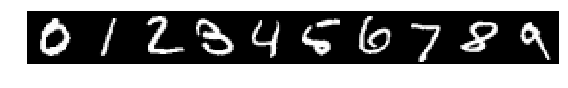

Reconstructed


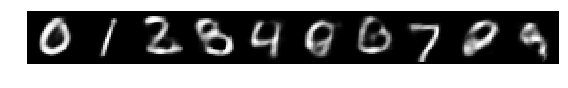

In [6]:
# Reconstruct from training data
print("Reconstruct from training data...")
ae_dnn.reconstruct(x_train, [1, 3, 5, 7, 2, 0, 13, 15, 17, 4], 1, 10)
# Reconstruct from testing data
print("Reconstruct from testing data...")
ae_dnn.reconstruct(x_test, [3, 2, 1, 18, 4, 8, 11, 0, 61, 7], 1, 10)

#### Sampling

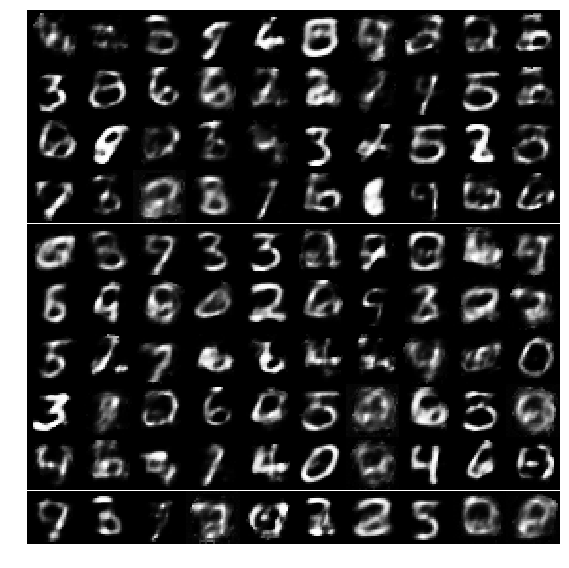

In [7]:
# Generate from sampling latent code
ae_dnn.generate(rows=10, columns=10)

## CNN Ver.

### Build Model

In [8]:
ae_cnn = AE((28, 28, 1), 32)


=== Encoder ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 16)        2320      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 7, 7, 16)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0   

### Train Model

In [9]:
ae_cnn.train(x_train, 256, 100)

Epoch 1/100
60000/60000 [==============================] - 56s 938us/step - loss: 0.0912
Epoch 2/100
60000/60000 [==============================] - 56s 931us/step - loss: 0.0306
Epoch 3/100
60000/60000 [==============================] - 56s 932us/step - loss: 0.0241
Epoch 4/100
60000/60000 [==============================] - 56s 939us/step - loss: 0.0215
Epoch 5/100
60000/60000 [==============================] - 57s 954us/step - loss: 0.0200
Epoch 6/100
60000/60000 [==============================] - 57s 957us/step - loss: 0.0189
Epoch 7/100
60000/60000 [==============================] - 57s 958us/step - loss: 0.0181
Epoch 8/100
60000/60000 [==============================] - 57s 957us/step - loss: 0.0175
Epoch 9/100
60000/60000 [==============================] - 57s 949us/step - loss: 0.0170
Epoch 10/100
60000/60000 [==============================] - 57s 952us/step - loss: 0.0165
Epoch 11/100
60000/60000 [==============================] - 57s 945us/step - loss: 0.0162
Epoch 12/100
60000/

60000/60000 [==============================] - 58s 959us/step - loss: 0.0115
Epoch 93/100
60000/60000 [==============================] - 58s 974us/step - loss: 0.0115
Epoch 94/100
60000/60000 [==============================] - 58s 969us/step - loss: 0.0115
Epoch 95/100
60000/60000 [==============================] - 57s 956us/step - loss: 0.0115
Epoch 96/100
60000/60000 [==============================] - 58s 960us/step - loss: 0.0115
Epoch 97/100
60000/60000 [==============================] - 58s 974us/step - loss: 0.0115
Epoch 98/100
60000/60000 [==============================] - 58s 971us/step - loss: 0.0115
Epoch 99/100
60000/60000 [==============================] - 58s 960us/step - loss: 0.0114
Epoch 100/100
60000/60000 [==============================] - 57s 945us/step - loss: 0.0114


### Plot Result

#### Reconstruct

Reconstruct from training data...
Original


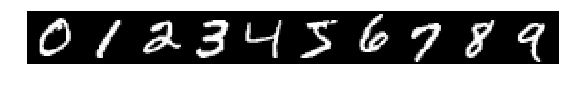

Reconstructed


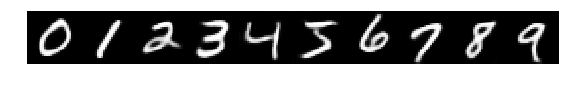

Reconstruct from testing data...
Original


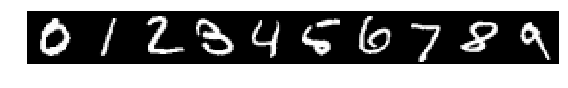

Reconstructed


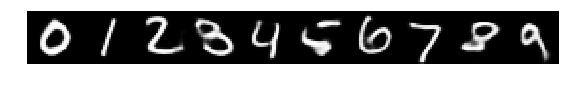

In [10]:
# Reconstruct from training data
print("Reconstruct from training data...")
ae_cnn.reconstruct(x_train, [1, 3, 5, 7, 2, 0, 13, 15, 17, 4], 1, 10)
# Reconstruct from testing data
print("Reconstruct from testing data...")
ae_cnn.reconstruct(x_test, [3, 2, 1, 18, 4, 8, 11, 0, 61, 7], 1, 10)

#### Sampling

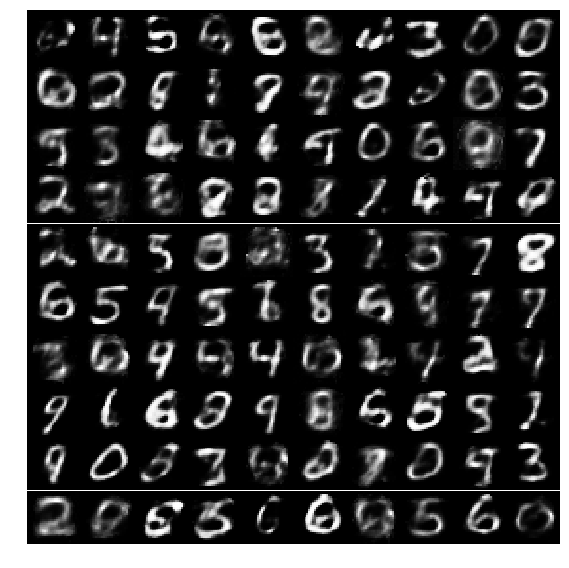

In [11]:
# Generate from sampling latent code
ae_dnn.generate(rows=10, columns=10)

# VAE

**See reference [here](https://github.com/SitiBanc/1062-Deep-Learning/blob/master/%5B2018%5DDL_HW3/VAE.ipynb)**